In [1]:
%matplotlib inline
import tensorflow as tf
# sa = tf.Session()
# sa.close()
# import tensorflow as tf
# tf.Graph.as_default
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
gpuname = [x.name for x in local_device_protos if x.device_type == 'GPU']
tf.device(gpuname)
# sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 4}))
# os.environ["CUDA_VISIBLE_DEVICES"]="4"
import keras
from keras.models import Sequential
from keras.utils import multi_gpu_model
from keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import json
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import pylab
import copy
import os
import ast
import sys
import cv2
import matplotlib.patches as patches
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Using TensorFlow backend.


In [133]:
df_train = pd.read_csv('final_train_path_bbox_category_after_augment_after_resize_100.csv', low_memory=False)
df_val = pd.read_csv('final_val_path_bbox_category_after_augment_after_resize_100.csv', low_memory=False)
df_train_old = pd.read_csv('final_train_path_bbox_category_for_augment_after_resize_100.csv', low_memory=False)
df_val_old = pd.read_csv('final_val_path_bbox_category_for_augment_after_resize_100.csv', low_memory=False)
categories = pd.read_csv('categories.csv', index_col=['id'])
df_train.bboxes = df_train.bboxes.apply(lambda x : ast.literal_eval(x))
df_train_old.bboxes = df_train_old.bboxes.apply(lambda x : ast.literal_eval(x))
df_val.bboxes = df_val.bboxes.apply(lambda x : ast.literal_eval(x))
df_val_old.bboxes = df_val_old.bboxes.apply(lambda x : ast.literal_eval(x))
df_train.category_ids = df_train.category_ids.apply(lambda x : ast.literal_eval(x))
df_train_old.category_ids = df_train_old.category_ids.apply(lambda x : ast.literal_eval(x))
df_val.category_ids = df_val.category_ids.apply(lambda x : ast.literal_eval(x))
df_val_old.category_ids = df_val_old.category_ids.apply(lambda x : ast.literal_eval(x))

In [111]:
df_train.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/augmented/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 48.07472527472527, '...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/augmented/000000372220.jpg,"[{'x1': 16.675, 'y1': 92.25974025974027, 'x2':...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/augmented/000000211935.jpg,"[{'x1': 88.63380281690142, 'y1': 93.2296875, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/augmented/000000513983.jpg,"[{'x1': 4.302083333333334, 'y1': 12.0968749999...","[19, 61]"
4,data/coco/train2017/augmented/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [112]:
df_val.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/augmented/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 1.5571030640668369, '...",[65]
1,data/coco/val2017/augmented/000000405972.jpg,"[{'x1': 4.143192488262912, 'y1': 33.025, 'x2':...","[22, 22, 22]"
2,data/coco/val2017/augmented/000000047010.jpg,"[{'x1': 35.3875, 'y1': 36.310937500000016, 'x2...","[25, 25, 25, 21]"
3,data/coco/val2017/augmented/000000085823.jpg,"[{'x1': 19.39344262295082, 'y1': 38.2296875000...","[24, 24, 24]"
4,data/coco/val2017/augmented/000000225184.jpg,"[{'x1': 48.59956236323851, 'y1': 55.19375, 'x2...","[18, 20, 20, 20]"


In [113]:
df_train_old.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 15.296703296703297, ...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/000000372220.jpg,"[{'x1': 92.25974025974027, 'y1': 78.7234375, '...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/000000211935.jpg,"[{'x1': 93.2296875, 'y1': 88.63380281690142, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/000000513983.jpg,"[{'x1': 24.8390625, 'y1': 4.302083333333334, '...","[19, 61]"
4,data/coco/train2017/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [114]:
df_val_old.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 0.6880222841225628, '...",[65]
1,data/coco/val2017/000000405972.jpg,"[{'x1': 17.884375000000002, 'y1': 4.1431924882...","[22, 22, 22]"
2,data/coco/val2017/000000047010.jpg,"[{'x1': 47.309374999999996, 'y1': 41.708333333...","[25, 25, 25, 21]"
3,data/coco/val2017/000000085823.jpg,"[{'x1': 23.3890625, 'y1': 0.15690866510538642,...","[24, 24, 24]"
4,data/coco/val2017/000000225184.jpg,"[{'x1': 42.155361050328224, 'y1': 55.19375, 'x...","[18, 20, 20, 20]"


In [134]:
categories.head()

,name,supercategory
id,,
1,person,person
2,bicycle,vehicle
3,car,vehicle
4,motorcycle,vehicle
5,airplane,vehicle


In [116]:
df_val_final = pd.concat([df_val_old, df_val]).reset_index(drop=True)
df_val_final.head()

,filepath,bboxes,category_ids
0,data/coco/val2017/000000217219.jpg,"[{'x1': 0.1265625, 'y1': 0.6880222841225628, '...",[65]
1,data/coco/val2017/000000405972.jpg,"[{'x1': 17.884375000000002, 'y1': 4.1431924882...","[22, 22, 22]"
2,data/coco/val2017/000000047010.jpg,"[{'x1': 47.309374999999996, 'y1': 41.708333333...","[25, 25, 25, 21]"
3,data/coco/val2017/000000085823.jpg,"[{'x1': 23.3890625, 'y1': 0.15690866510538642,...","[24, 24, 24]"
4,data/coco/val2017/000000225184.jpg,"[{'x1': 42.155361050328224, 'y1': 55.19375, 'x...","[18, 20, 20, 20]"


In [117]:
df_train_final = pd.concat([df_train_old, df_train]).reset_index(drop=True)
df_train_final.head()

,filepath,bboxes,category_ids
0,data/coco/train2017/000000457868.jpg,"[{'x1': 47.2890625, 'y1': 15.296703296703297, ...","[28, 28, 28, 28, 1, 1, 1, 27, 31, 8, 1, 3, 1]"
1,data/coco/train2017/000000372220.jpg,"[{'x1': 92.25974025974027, 'y1': 78.7234375, '...","[77, 1, 1, 31, 1]"
2,data/coco/train2017/000000211935.jpg,"[{'x1': 93.2296875, 'y1': 88.63380281690142, '...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3]"
3,data/coco/train2017/000000513983.jpg,"[{'x1': 24.8390625, 'y1': 4.302083333333334, '...","[19, 61]"
4,data/coco/train2017/000000467951.jpg,"[{'x1': 19.6390625, 'y1': 51.22291666666668, '...","[86, 86, 67, 86]"


In [44]:
X_train = np.empty((len(df_train_final), 100, 100, 3), dtype=np.single)
for index, row in df_train_final.iterrows():
    im = cv2.imread(row['filepath'])
    X_train[index, ...] = im/255.

In [45]:
X_train

array([[[[1.        , 1.        , 0.9490196 ],
         [0.8980392 , 0.8627451 , 0.80784315],
         [0.54509807, 0.49411765, 0.4392157 ],
         ...,
         [0.72156864, 0.73333335, 0.7254902 ],
         [0.72156864, 0.73333335, 0.7254902 ],
         [0.6862745 , 0.69803923, 0.6901961 ]],

        [[0.99215686, 0.95686275, 0.90588236],
         [0.5764706 , 0.5411765 , 0.49019608],
         [0.5764706 , 0.5294118 , 0.48235294],
         ...,
         [0.6745098 , 0.6862745 , 0.6784314 ],
         [0.74509805, 0.75686276, 0.7490196 ],
         [0.76862746, 0.78039217, 0.77254903]],

        [[0.654902  , 0.61960787, 0.5803922 ],
         [0.5058824 , 0.47058824, 0.43137255],
         [0.43529412, 0.39607844, 0.35686275],
         ...,
         [0.8156863 , 0.827451  , 0.81960785],
         [0.69411767, 0.69803923, 0.6901961 ],
         [0.75686276, 0.7607843 , 0.7529412 ]],

        ...,

        [[0.38039216, 0.70980394, 0.59607846],
         [0.3647059 , 0.6862745 , 0.57254905]

In [46]:
X_train.shape

(234532, 100, 100, 3)

In [47]:
X_val = np.empty((len(df_val_final), 100, 100, 3), dtype=np.single)
for index, row in df_val_final.iterrows():
    im = cv2.imread(row['filepath'])
    X_val[index, ...] = im/255.

In [48]:
X_val.shape

(9904, 100, 100, 3)

In [49]:
X_val

array([[[[0.5882353 , 0.5411765 , 0.44705883],
         [0.5882353 , 0.5411765 , 0.44705883],
         [0.5882353 , 0.5411765 , 0.44705883],
         ...,
         [0.6862745 , 0.6156863 , 0.54901963],
         [0.49019608, 0.41960785, 0.3529412 ],
         [0.30980393, 0.23921569, 0.17254902]],

        [[0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         ...,
         [0.73333335, 0.65882355, 0.5764706 ],
         [0.7294118 , 0.654902  , 0.57254905],
         [0.56078434, 0.4862745 , 0.40392157]],

        [[0.58431375, 0.5372549 , 0.44313726],
         [0.58431375, 0.5372549 , 0.44313726],
         [0.5803922 , 0.53333336, 0.4392157 ],
         ...,
         [0.75686276, 0.6862745 , 0.57254905],
         [0.78039217, 0.7058824 , 0.6       ],
         [0.7607843 , 0.6862745 , 0.5803922 ]],

        ...,

        [[0.654902  , 0.68235296, 0.7490196 ],
         [0.5921569 , 0.64705884, 0.72156864]

In [50]:
np.save('/scratch/davda.g/X_val_new', X_val)
np.save('/scratch/davda.g/X_train_new', X_train)

In [122]:
bigl = []
for x in np.arange(len(df_val_final)):
    l = ['e','f']
    bigl.append(l)
df_val_final['labels'] = bigl
bigt = []
for x in np.arange(len(df_train_final)):
    l = ['e','f']
    bigt.append(l)
df_train_final['labels'] = bigt

In [136]:
for i, row in df_val_final.iterrows():
    ll = []
    l = row['category_ids']
    for x in l:
        ll.append(categories['name'][x])
    row['labels'] = ll

In [138]:
for i, row in df_train_final.iterrows():
    ll = []
    l = row['category_ids']
    for x in l:
        ll.append(categories['name'][x])
    row['labels'] = ll

In [139]:
df_val_final.to_csv('merged_val_after_resize_100.csv', index=False)
df_train_final.to_csv('merged_train_after_resize_100.csv', index=False)

In [2]:
df_train_final = pd.read_csv('merged_train_after_resize_100.csv', low_memory=False)
df_val_final = pd.read_csv('merged_val_after_resize_100.csv', low_memory=False)
df_train_final.bboxes = df_train_final.bboxes.apply(lambda x : ast.literal_eval(x))
df_train_final.category_ids = df_train_final.category_ids.apply(lambda x : ast.literal_eval(x))
df_train_final.labels = df_train_final.labels.apply(lambda x : ast.literal_eval(x))
df_val_final.bboxes = df_val_final.bboxes.apply(lambda x : ast.literal_eval(x))
df_val_final.category_ids = df_val_final.category_ids.apply(lambda x : ast.literal_eval(x))
df_val_final.labels = df_val_final.labels.apply(lambda x : ast.literal_eval(x))

In [3]:
X_train = np.load('/scratch/davda.g/X_train_new.npy')
X_val = np.load('/scratch/davda.g/X_val_new.npy')

In [4]:
s = df_val_final['labels']
s = s.tolist()
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(s)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

1. airplane
2. apple
3. backpack
4. banana
5. baseball bat
6. baseball glove
7. bear
8. bed
9. bench
10. bicycle
11. bird
12. boat
13. book
14. bottle
15. bowl
16. broccoli
17. bus
18. cake
19. car
20. carrot
21. cat
22. cell phone
23. chair
24. clock
25. couch
26. cow
27. cup
28. dining table
29. dog
30. donut
31. elephant
32. fire hydrant
33. fork
34. frisbee
35. giraffe
36. hair drier
37. handbag
38. horse
39. hot dog
40. keyboard
41. kite
42. knife
43. laptop
44. microwave
45. motorcycle
46. mouse
47. orange
48. oven
49. parking meter
50. person
51. pizza
52. potted plant
53. refrigerator
54. remote
55. sandwich
56. scissors
57. sheep
58. sink
59. skateboard
60. skis
61. snowboard
62. spoon
63. sports ball
64. stop sign
65. suitcase
66. surfboard
67. teddy bear
68. tennis racket
69. tie
70. toaster
71. toilet
72. toothbrush
73. traffic light
74. train
75. truck
76. tv
77. umbrella
78. vase
79. wine glass
80. zebra


In [5]:
s = df_train_final['labels']
s = s.tolist()
mlbt = MultiLabelBinarizer()
train_labels = mlbt.fit_transform(s)
for (i, label) in enumerate(mlbt.classes_):
    print("{}. {}".format(i + 1, label))

1. airplane
2. apple
3. backpack
4. banana
5. baseball bat
6. baseball glove
7. bear
8. bed
9. bench
10. bicycle
11. bird
12. boat
13. book
14. bottle
15. bowl
16. broccoli
17. bus
18. cake
19. car
20. carrot
21. cat
22. cell phone
23. chair
24. clock
25. couch
26. cow
27. cup
28. dining table
29. dog
30. donut
31. elephant
32. fire hydrant
33. fork
34. frisbee
35. giraffe
36. hair drier
37. handbag
38. horse
39. hot dog
40. keyboard
41. kite
42. knife
43. laptop
44. microwave
45. motorcycle
46. mouse
47. orange
48. oven
49. parking meter
50. person
51. pizza
52. potted plant
53. refrigerator
54. remote
55. sandwich
56. scissors
57. sheep
58. sink
59. skateboard
60. skis
61. snowboard
62. spoon
63. sports ball
64. stop sign
65. suitcase
66. surfboard
67. teddy bear
68. tennis racket
69. tie
70. toaster
71. toilet
72. toothbrush
73. traffic light
74. train
75. truck
76. tv
77. umbrella
78. vase
79. wine glass
80. zebra


In [22]:
model1 = Sequential()
model1.add(ZeroPadding2D((1,1),input_shape=(100,100,3)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(512, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(512, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(512, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(1024, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(1024, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(1024, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(2048, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(2048, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(ZeroPadding2D((1,1)))
model1.add(Conv2D(2048, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(2048, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(4096, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(len(mlbt.classes_)))
model1.add(Activation('sigmoid'))

In [23]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_33 (ZeroPaddi (None, 102, 102, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_37 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
zero_padding2d_34 (ZeroPaddi (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
batch_normalization_38 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 64)        0         
__________

In [24]:
sgd = SGD(momentum=0.9, lr=0.1)
filepath="seq_new_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=15, min_lr=0.001)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
callbacks_list = [reduce_lr, checkpoint, earlyStopping]

In [25]:
# parallel_model = multi_gpu_model(model, gpus=4)
# parallel_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model1.compile(metrics=['accuracy'], optimizer=sgd, loss='binary_crossentropy')

In [26]:
history = model1.fit(X_train, train_labels, batch_size=128, epochs=100,
                    validation_data = (X_val,labels),callbacks = callbacks_list)

Train on 234532 samples, validate on 9904 samples
Epoch 1/100
234532/234532 [==============================] - 3355s 14ms/step - loss: 0.1540 - acc: 0.9553 - val_loss: 0.1274 - val_acc: 0.9646

Epoch 00001: val_acc improved from -inf to 0.96458, saving model to seq_new_weights.best.hdf5
Epoch 2/100
234532/234532 [==============================] - 3325s 14ms/step - loss: 0.1263 - acc: 0.9651 - val_loss: 0.1285 - val_acc: 0.9652

Epoch 00002: val_acc improved from 0.96458 to 0.96516, saving model to seq_new_weights.best.hdf5
Epoch 3/100
234532/234532 [==============================] - 3324s 14ms/step - loss: 0.1262 - acc: 0.9653 - val_loss: 0.1412 - val_acc: 0.9642

Epoch 00003: val_acc did not improve from 0.96516
Epoch 4/100
234532/234532 [==============================] - 3323s 14ms/step - loss: 0.1256 - acc: 0.9653 - val_loss: 0.1287 - val_acc: 0.9649

Epoch 00004: val_acc did not improve from 0.96516
Epoch 5/100
234532/234532 [==============================] - 3328s 14ms/step - loss

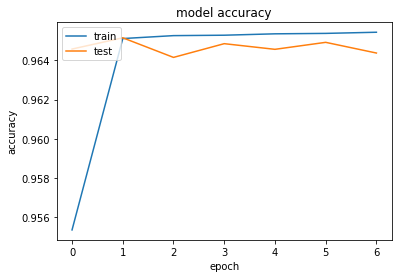

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

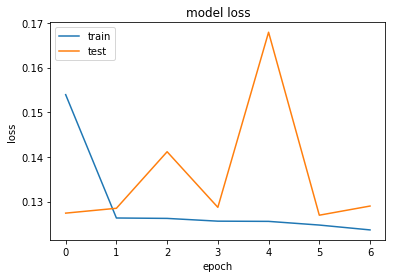

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()